## Portfolio optimization with Variational Quantum Eigensolver

### Step1:
**Download the stock price data from yahoo finance**

In [1]:
import pandas as pd
import yfinance as yf
assets = "AAPL MSFT AMZN TSLA GOOG BRK-B"
StockStartDate = '2018-01-01'
StockEndDate = '2018-12-31'
interval = '1d'

df = yf.download(assets, start=StockStartDate,\
                  end=StockEndDate, interval=interval, auto_adjust=False)['Close']
ret = df.pct_change().dropna()

R = ret.mean()*252
Sigma = ret.cov()*252

[*********************100%***********************]  6 of 6 completed


The objective of using the VQE is to minimize the following equation

$$ \text{min}_x \gamma x^T\sigma x - \mu^Tx + P(1^Tx - B)^2$$

which we will convert in this form;
$$ \text{min}_{z_k\in {-1,1}} \sum_i\sum_{j>i} \dfrac{(\gamma\sigma_{ij} +  P)}{2} +  \sum_i \left[-\dfrac{\gamma}{2}\sum_j\sigma_{ij} + \dfrac{1}{2}\mu_i - \dfrac{P(N-2B)}{2} \right]z_i + \dfrac{\gamma}{4} \sum_i\sum_j\sigma_{ij} + \dfrac{\gamma}{4} \sum_i\sigma_{ii} - \dfrac{1}{2} \sum_i\mu_{i} + \dfrac{P}{4}[N + (N-2B)^2] 
$$

where, 
* N is the total number of assets
* $\gamma$ is the risk aversion coeff.
* B is the Budget
* P is the penalty

In [2]:
import pennylane as qml
import numpy as np

# define the parameters in H
N = 6
gamma = 1
B = 3
P = 1.0

ZZ = [qml.PauliZ(i)@qml.PauliZ(j) for i in range(N) for j in range(i+1, N) ]
ZZ_coeff = [0.5*(gamma*Sigma.values[i][j]+P) for i in range(N) for j in range(i+1, N)]
Z = [qml.PauliZ(i) for i in range(N)]
Z_coeff = [-0.5*gamma*(sum(Sigma.values[i][:])) + 0.5*R[i] - 0.5*P*(N-2*B) for i in range(N)]
C = 0.25*gamma*(sum(sum(Sigma.values)) + np.trace(Sigma)) - 0.5*sum(R) + 0.25*P*(N + (N-2*B)**2)

print('ZZ', ZZ)
print('ZZ_c', ZZ_coeff)
print('Z', Z)
print('Z_co', Z_coeff)
# Hamiltonian
obs = ZZ + Z
coeffs  = ZZ_coeff + Z_coeff
H = qml.Hamiltonian(coeffs, obs, grouping_type="qwc")
print(H)

ZZ [Z(0) @ Z(1), Z(0) @ Z(2), Z(0) @ Z(3), Z(0) @ Z(4), Z(0) @ Z(5), Z(1) @ Z(2), Z(1) @ Z(3), Z(1) @ Z(4), Z(1) @ Z(5), Z(2) @ Z(3), Z(2) @ Z(4), Z(2) @ Z(5), Z(3) @ Z(4), Z(3) @ Z(5), Z(4) @ Z(5)]
ZZ_c [np.float64(0.5344105166555051), np.float64(0.517186958129604), np.float64(0.5276058451707686), np.float64(0.5284104186438747), np.float64(0.5269455205188833), np.float64(0.5203469388752823), np.float64(0.5383128055275728), np.float64(0.5397427893760345), np.float64(0.5379328572142495), np.float64(0.5195740062722891), np.float64(0.520589036782088), np.float64(0.5190662992445695), np.float64(0.532960076637407), np.float64(0.5281482111593488), np.float64(0.5325399426746356)]
Z [Z(0), Z(1), Z(2), Z(3), Z(4), Z(5)]
Z_co [np.float64(-0.20475301980353672), np.float64(-0.09339780345937157), np.float64(-0.09729533859356473), np.float64(-0.17989949625472548), np.float64(-0.09587825727058946), np.float64(-0.2120062971060691)]
0.5344105166555051 * (Z(0) @ Z(1)) + 0.517186958129604 * (Z(0) @ Z(2))

C:\Users\kafar\AppData\Local\Temp\ipykernel_11480\3798601423.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Z_coeff = [-0.5*gamma*(sum(Sigma.values[i][:])) + 0.5*R[i] - 0.5*P*(N-2*B) for i in range(N)]


In [3]:
# preparing the ansatz state

p = 2 # circuit repetitions
def ansatz(params, qubits, depth = 2):
    for q in range(qubits):
        qml.RY(params[q], wires = q)
    for d in range(1, depth +1):
        for q in range(qubits-1):
            qml.CNOT(wires=[q,q+1])
        for q in range(qubits):
            qml.RY(params[d*qubits+q], wires=q)
    

In [4]:
dev =qml.device("default.qubit", wires=N)

# set the cost function on dev
@qml.qnode(dev, diff_method= "parameter-shift")
def cost(x):
    ansatz(x,qubits=N)
    return qml.expval(H)

# Analyze the optimized circuit
@qml.qnode(dev)
def probability_circuit(params):
    ansatz(params, qubits=N)
    return qml.probs(wires=range(N))

In [ ]:
opt = qml.QNGOptimizer(stepsize=0.02)
max_steps = 600
init_params = qml.numpy.array(np.random.rand((p+1) * N), requires_grad=True)

params = init_params
old_cost = 9999.99999
for i in range(max_steps):

    params = opt.step(cost, params)
    obj_value = cost(params)
    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, obj_value))
        if np.round(old_cost, 7) == np.round(obj_value, 7):
            break
        else:
            old_cost = obj_value

print("Optimized parameters: {}".format(params))
print("Optimized objective function value: {}".format(obj_value))

Cost after step     5: -0.0444798
Cost after step    10: -0.5122786
Cost after step    15: -0.8854504
Cost after step    20: -1.0868161
Cost after step    25: -1.1729723
Cost after step    30: -1.2218387
Cost after step    35: -1.2598205
Cost after step    40: -1.2945146
Cost after step    45: -1.3285451
Cost after step    50: -1.3627413
Cost after step    55: -1.3970282
Cost after step    60: -1.4308230
Cost after step    65: -1.4632965
Cost after step    70: -1.4935755
Cost after step    75: -1.5209082
Cost after step    80: -1.5447873
Cost after step    85: -1.5650160
Cost after step    90: -1.5816982
Cost after step    95: -1.5951679
Cost after step   100: -1.6058903
Cost after step   105: -1.6143729
Cost after step   110: -1.6211053
Cost after step   115: -1.6265323
Cost after step   120: -1.6310580
Cost after step   125: -1.6350907
Cost after step   130: -1.6391521
Cost after step   135: -1.6440283
Cost after step   140: -1.6504118
Cost after step   145: -1.6577515
Cost after ste

Final solution: 011010, with prob=0.999270


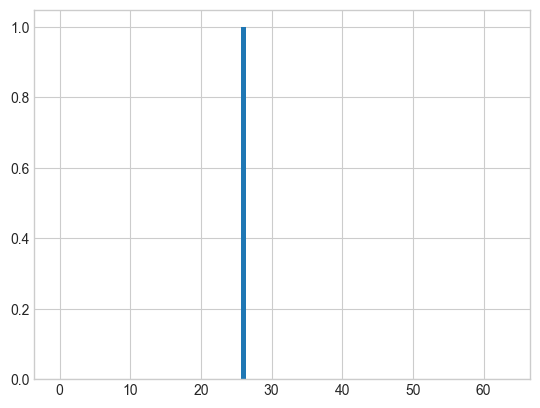

In [8]:
import matplotlib.pyplot  as plt

probs = probability_circuit(params)
print("Final solution: {:06b}, with prob={:5f}".format(np.argmax(probs), max(probs)))
plt.style.use("seaborn-v0_8-whitegrid")

plt.bar(range(2 ** len(range(N))), probs)
plt.show()

In [13]:
import itertools
all_combinations = itertools.product([0,1] , repeat = N)

E_g = 99999.99999
for x in all_combinations:
    print(Sigma)
    E = gamma*np.dot(x, np.dot(Sigma, x)) - np.dot(R,x) + P*(sum(x) - B) **2
    if E < E_g:
        E_g = E
        sol = x
print("Exact solution{}".format(sol))

Ticker      AAPL      AMZN     BRK-B      GOOG      MSFT      TSLA
Ticker                                                            
AAPL    0.082874  0.068821  0.034374  0.055212  0.056821  0.053891
AMZN    0.068821  0.130932  0.040694  0.076626  0.079486  0.075866
BRK-B   0.034374  0.040694  0.051331  0.039148  0.041178  0.038133
GOOG    0.055212  0.076626  0.039148  0.079477  0.065920  0.056296
MSFT    0.056821  0.079486  0.041178  0.065920  0.080550  0.065080
TSLA    0.053891  0.075866  0.038133  0.056296  0.065080  0.344898
Ticker      AAPL      AMZN     BRK-B      GOOG      MSFT      TSLA
Ticker                                                            
AAPL    0.082874  0.068821  0.034374  0.055212  0.056821  0.053891
AMZN    0.068821  0.130932  0.040694  0.076626  0.079486  0.075866
BRK-B   0.034374  0.040694  0.051331  0.039148  0.041178  0.038133
GOOG    0.055212  0.076626  0.039148  0.079477  0.065920  0.056296
MSFT    0.056821  0.079486  0.041178  0.065920  0.080550  0.06

n: Number of assets

$x_i$: Proportion of total capital invested in asset i, for i=1,2,..n

$\mu i$: Expected return of asset i

$\sigma$: Covariance matrix of asset returns (i.e., risk between assets)
Objective:

Minimize portfolio variance (risk):
$\min{x} \quad x^T \Sigma x$

Subject to:

Return constraint:
$\sum_{i=1}^n x_i \mu i \geq R$

Budget constraint:
$\sum{i=1}^n x_i = 1$

Non-negativity (if short-selling not allowed):
$x_i \geq 0 \quad \forall i$